## Module 3 Assignment 1: House Prices: Advanced Regression Techniques (Kaggle)

##### Sachin Sharma
##### MSDS 422
##### 6 July 2024

#### Import Modules

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind, f_oneway
import statsmodels.api as sm
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import train_test_split, KFold, cross_validate
from numpy import mean, absolute
from sklearn.linear_model import Ridge, ElasticNet, LinearRegression, Lasso, LassoCV
from sklearn.metrics import r2_score, get_scorer, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler, PolynomialFeatures, LabelEncoder
import warnings
# Ignore all FutureWarnings
warnings.filterwarnings("ignore")
InteractiveShell.ast_node_interactivity = "all"

#### Data Preparation

In [2]:
housing_training_data = pd.read_csv('train.csv')
housing_training_data.shape
housing_training_data.head()

(1460, 81)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Details on Dependent Variable

We can start analyzing the distribution of the dataset's dependent variable, sale price, by generating summary statistics.

In [3]:
housing_training_data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

We can also construct a histogram and a boxplot to visualize the distribution of the sale price variable in this dataframe.

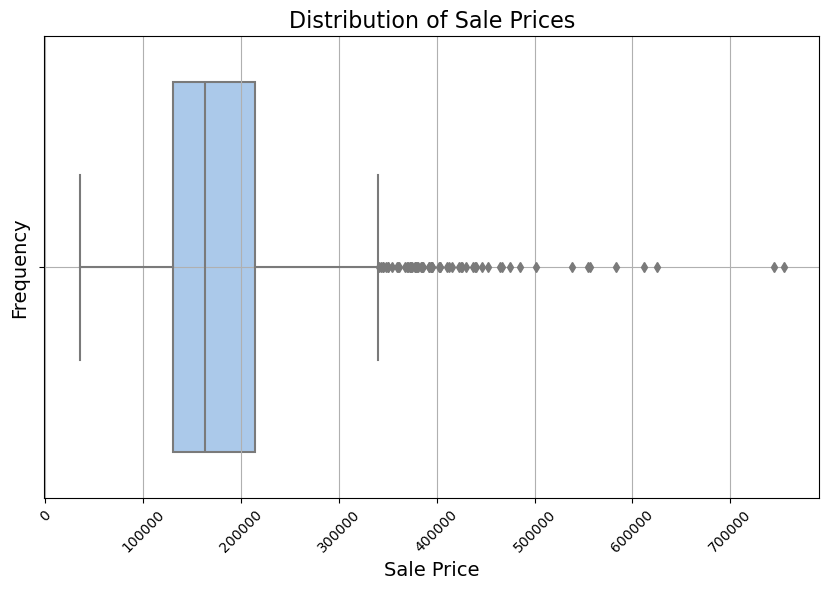

In [4]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=housing_training_data["SalePrice"], palette="pastel")
plt.title('Distribution of Sale Prices', fontsize=16)
plt.xlabel('Sale Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.show();

### Check for Missing Data and Outliers

In [5]:
# Calculate null counts, percentage of null values, and column types
null_count = housing_training_data.isnull().sum()
null_percentage = (null_count * 100) / len(housing_training_data)
column_type = housing_training_data.dtypes

# Combine the null counts, percentage, and column types into a summary DataFrame
null_summary = pd.concat([null_count, null_percentage, column_type], axis=1, keys=['Missing Count', 'Percentage Missing', 'Column Type'])

# Filter the summary to show only columns with missing values, sorted by percentage of missing values
null_summary_with_missing = null_summary[null_count > 0].sort_values('Percentage Missing', ascending=False)

# Display the summary of columns with missing values
null_summary_with_missing

,Missing Count,Percentage Missing,Column Type
PoolQC,1453,99.520548,object
MiscFeature,1406,96.301370,object
Alley,1369,93.767123,object
Fence,1179,80.753425,object
MasVnrType,872,59.726027,object
FireplaceQu,690,47.260274,object
LotFrontage,259,17.739726,float64
GarageType,81,5.547945,object
GarageYrBlt,81,5.547945,float64
GarageFinish,81,5.547945,object


We will address columns containing missing values in our exploratory data analysis by leveraging the percentage of null values, column types, and other available data columns that may offer insights useful for imputation.

We will remove columns with over 50% Null values.

In [6]:
# Drop columns with over 50% missing values: Alley, PoolQC, Fence, MiscFeature
housing_training_data.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)
housing_training_data.shape

(1460, 77)

We will assign null values

In [7]:
# List of non-numeric columns with more than one null value
columns_None = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 
                'FireplaceQu', 'GarageCond', 'MasVnrType', 'Electrical']

# Fill null values in non-numeric columns with 'None'
housing_training_data[columns_None] = housing_training_data[columns_None].fillna('None')

We establish the optimal null-handling approach for each numeric column. Null values in the Masonry veneer area are replaced with 0, nulls in Lot Frontage with the median, and nulls in Year Garage was built with the average of the year the garage was built and the year the house was built.

In [8]:
housing_training_data['MasVnrArea'].fillna(0, inplace=True)
lot_frontage_median = housing_training_data['LotFrontage'].median()
housing_training_data['LotFrontage'].fillna(lot_frontage_median, inplace=True)
avg_years = round((housing_training_data['GarageYrBlt'] - housing_training_data['YearBuilt']).mean())
# fill Nulls with avg bet year garage was built and year house was built 
housing_training_data['GarageYrBlt'].fillna(housing_training_data['YearBuilt']+avg_years, inplace=True)

Let's check if there are any null values available

In [9]:
# check if there are no more missing values in the dataframe
null_count = housing_training_data.isnull().sum()
null_count[null_count != 0]

Series([], dtype: int64)

### Heat Map between dependent and potential Predictor

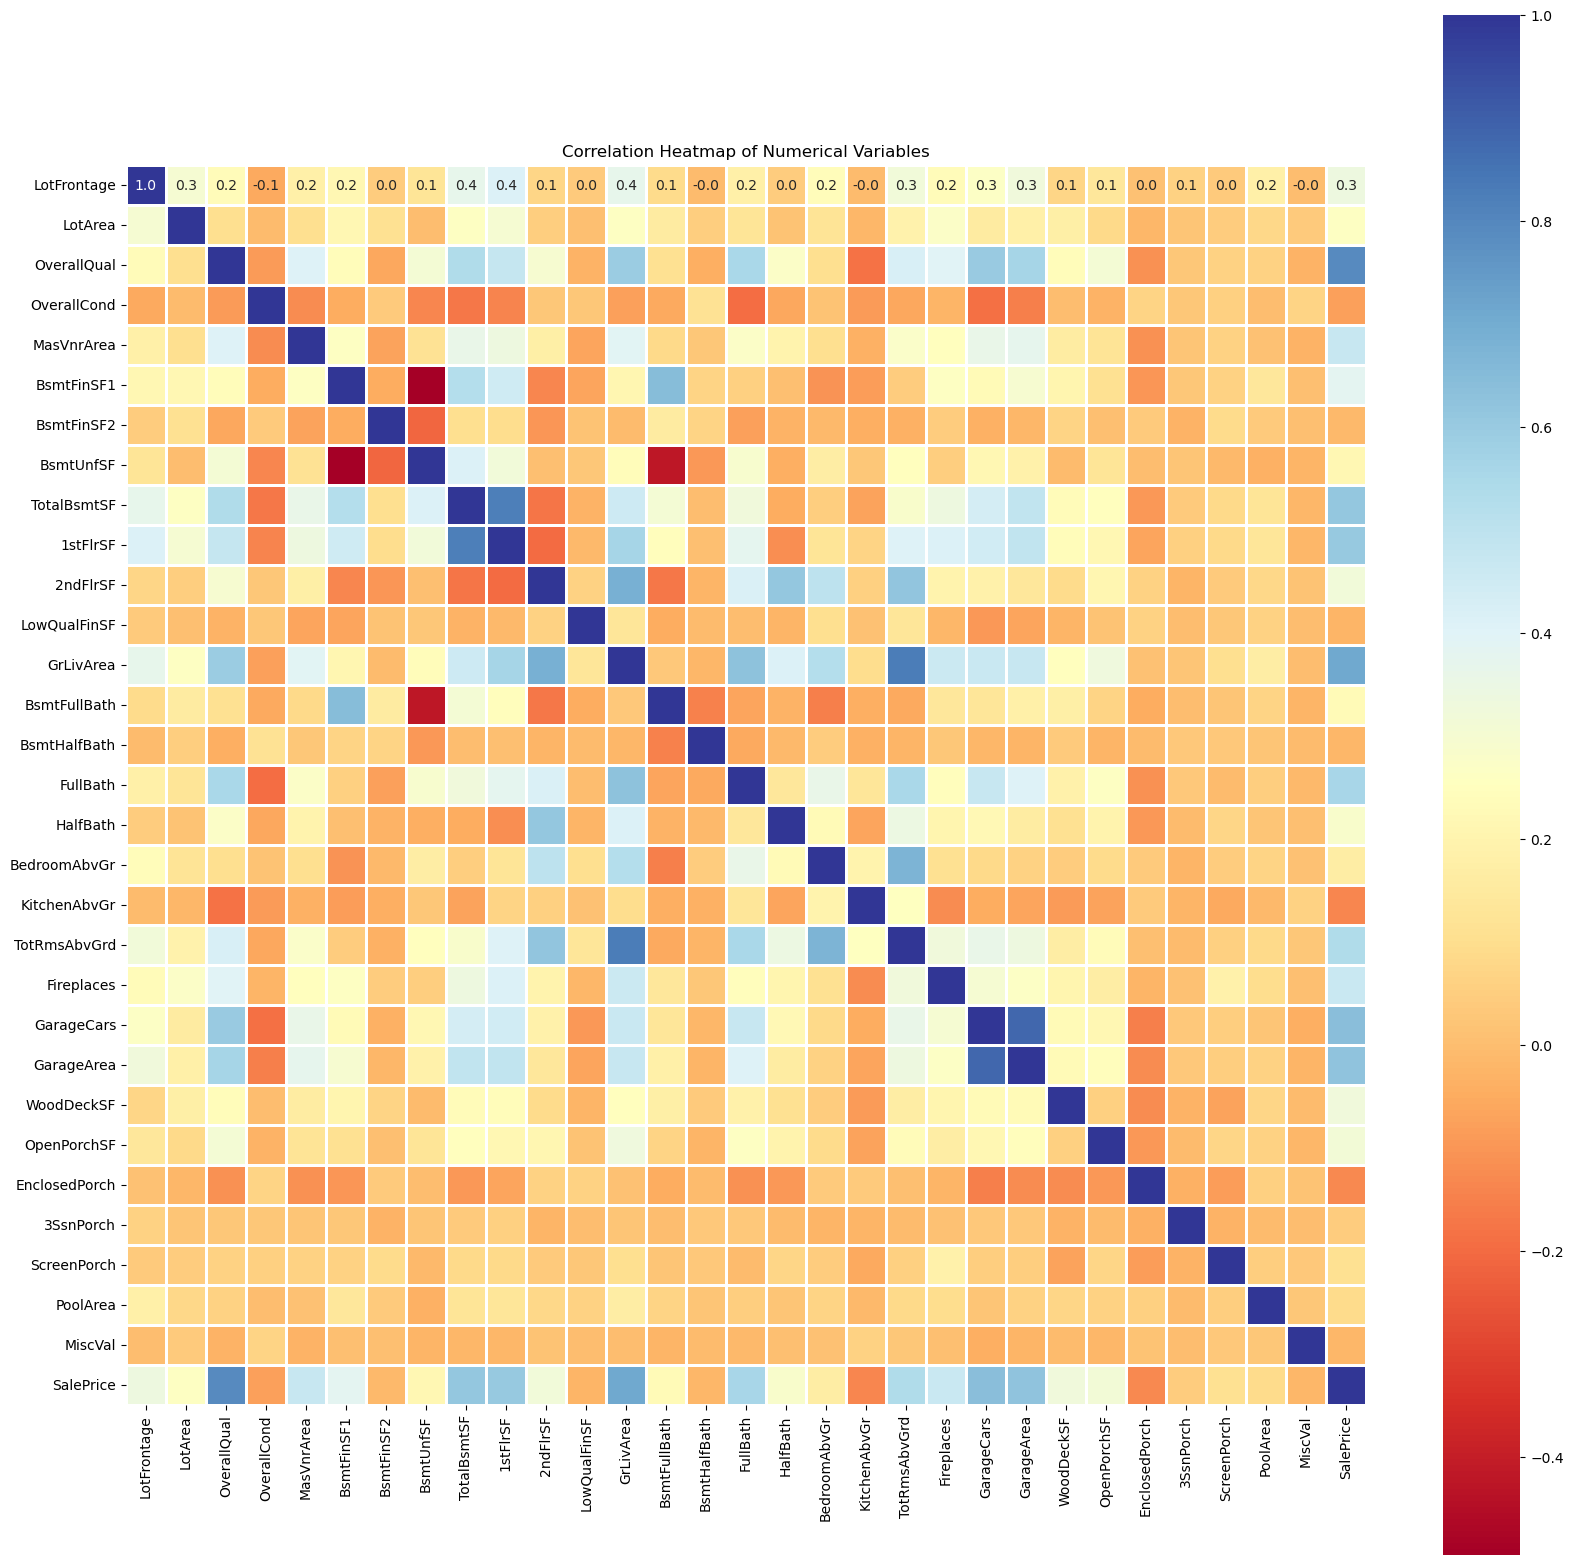

In [10]:
# Select numerical variables
numerical_vars = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
                 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
                 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
                 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']

# Create correlation matrix
df_corr_housing_training = housing_training_data[numerical_vars]
corrmat_housing_training = df_corr_housing_training.corr()

# Plot heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corrmat_housing_training, vmax=1, square=True, annot=True, cmap='RdYlBu', linewidths=0.8, fmt=".1f")
plt.title('Correlation Heatmap of Numerical Variables')
plt.show();

In [11]:
# Determine the correlation between each feature and SalePrice
cor_target = corrmat_housing_training["SalePrice"]
# Identify features with a correlation higher than 0.5
important_features = cor_target[cor_target > 0.5]
# Order the important features by correlation coefficient, highest first
important_features = important_features.sort_values(ascending=False)
# Show the important features
important_features

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
Name: SalePrice, dtype: float64

Below are plots that examine the relationship between variables of interest and sale price

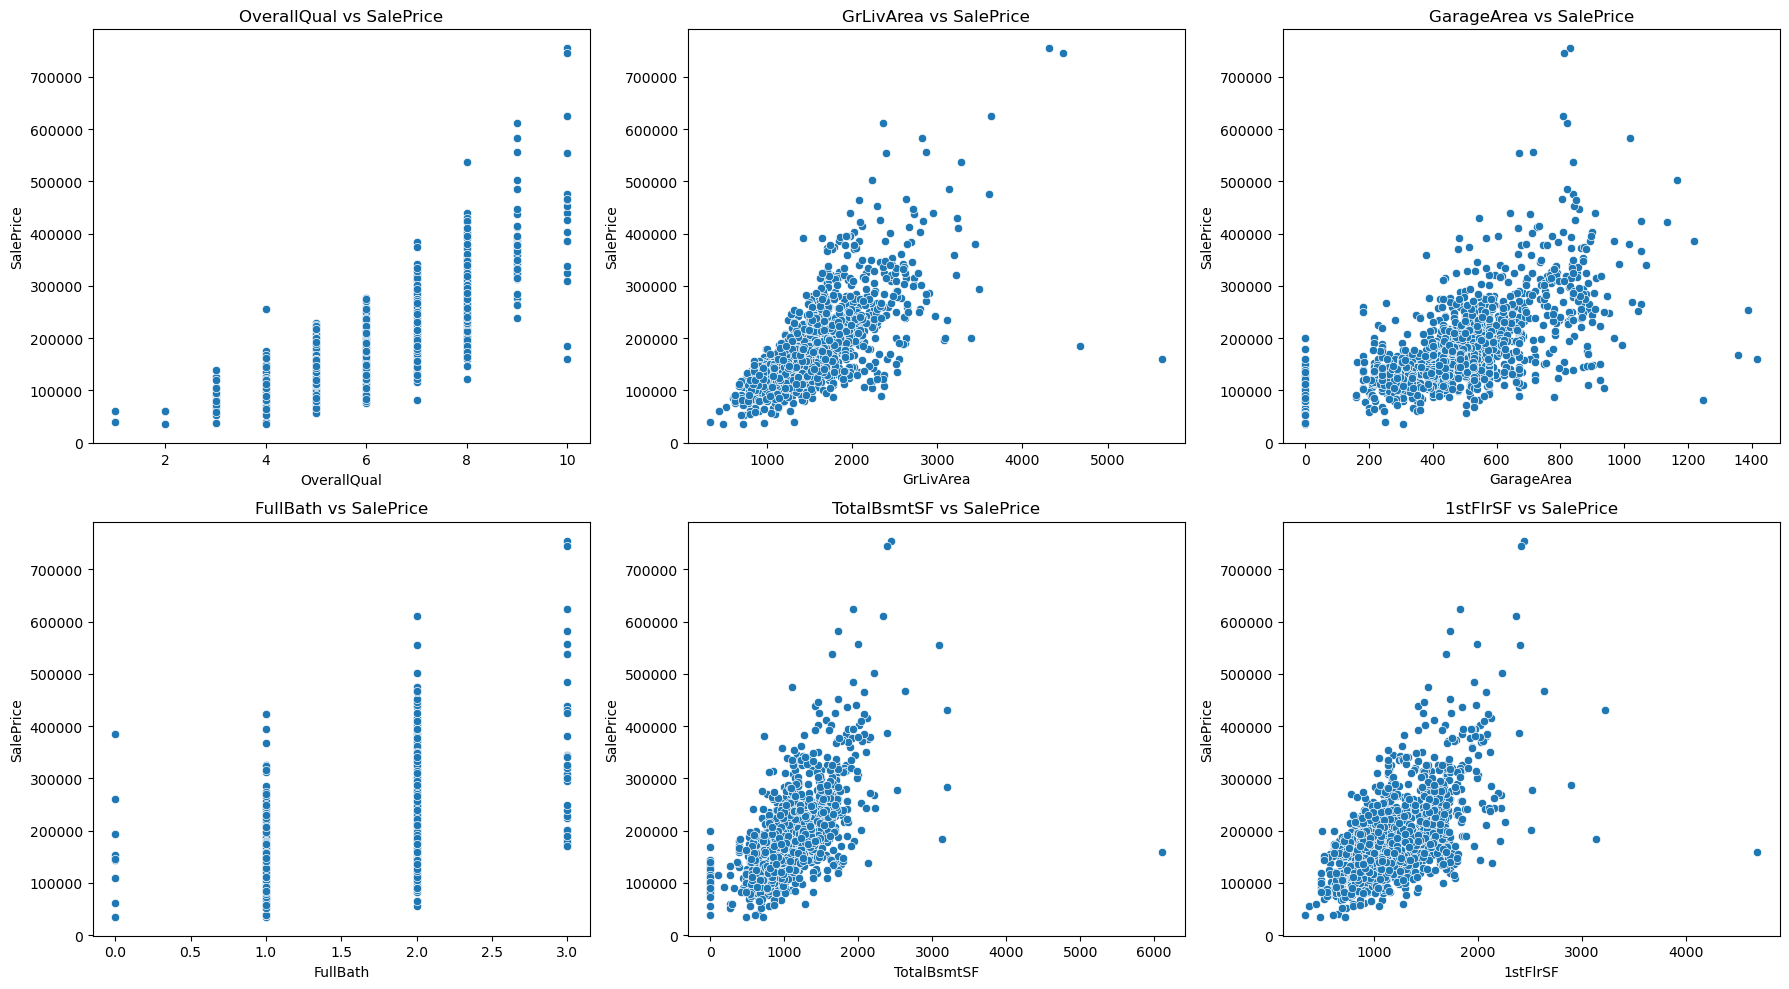

In [12]:
variables_of_interest = ['OverallQual', 'GrLivArea', 'GarageArea', 'FullBath', 'TotalBsmtSF', '1stFlrSF']

# Plotting relationships with SalePrice
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
for ax, var in zip(axes.flatten(), variables_of_interest):
    sns.scatterplot(x=housing_training_data[var], y=housing_training_data['SalePrice'], ax=ax)
    ax.set_title(f'{var} vs SalePrice')
plt.tight_layout()
plt.show();

To identify the most predictive binary categorical variables for a regression model, we will utilize boxplots and conduct t-tests to assess which binary indicators exhibit the strongest correlation with home sale prices.

In [13]:
categorical_variables = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
                        'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',  'RoofMatl',
                        'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
                        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
                        'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 
                        'GarageQual', 'GarageCond', 'PavedDrive',  'SaleType', 'SaleCondition','YearBuilt','GarageYrBlt',
                         'YrSold', 'MoSold']

# Calculate number of unique categories for each variable
category_counts = [len(housing_training_data[var].unique()) for var in categorical_variables]

# Create a DataFrame to summarize categorical variables and their category counts
categorical_variable_dictionary = {'Categorical Predictor': categorical_variables, 'Number of Categories': category_counts}
categorical_var_df = pd.DataFrame(categorical_variable_dictionary)

# Identify indicator variables (binary categorical variables)
indicator_variables_df = categorical_var_df[categorical_var_df['Number of Categories'] == 2]

# Identify non-indicator categorical variables (more than two categories)
non_indicator_categorial_vars_df = categorical_var_df[categorical_var_df['Number of Categories'] > 2]

# Display the results
print("Summary of Categorical Variables:")
print(", ".join(f"('{var}': {len(housing_training_data[var].unique())})" for var in categorical_variables))
print("\nIndicator Variables (Binary):")
print(", ".join(f"('{var}': {num})" for var, num in zip(indicator_variables_df['Categorical Predictor'], indicator_variables_df['Number of Categories'])))
# Print results for non_indicator_categorial_vars_df
print("\nNon-Indicator Categorical Variables (More than Two Categories):")
print(", ".join(f"('{var}': {num})" for var, num in zip(non_indicator_categorial_vars_df['Categorical Predictor'], non_indicator_categorial_vars_df['Number of Categories'])))

Summary of Categorical Variables:
('MSZoning': 5), ('Street': 2), ('LotShape': 4), ('LandContour': 4), ('Utilities': 2), ('LotConfig': 5), ('LandSlope': 3), ('Neighborhood': 25), ('Condition1': 9), ('Condition2': 8), ('BldgType': 5), ('HouseStyle': 8), ('RoofStyle': 6), ('RoofMatl': 8), ('Exterior1st': 15), ('Exterior2nd': 16), ('MasVnrType': 4), ('ExterQual': 4), ('ExterCond': 5), ('Foundation': 6), ('BsmtQual': 5), ('BsmtCond': 5), ('BsmtExposure': 5), ('BsmtFinType1': 7), ('BsmtFinType2': 7), ('Heating': 6), ('HeatingQC': 5), ('CentralAir': 2), ('Electrical': 6), ('KitchenQual': 4), ('Functional': 7), ('FireplaceQu': 6), ('GarageType': 7), ('GarageQual': 6), ('GarageCond': 6), ('PavedDrive': 3), ('SaleType': 9), ('SaleCondition': 6), ('YearBuilt': 112), ('GarageYrBlt': 102), ('YrSold': 5), ('MoSold': 12)

Indicator Variables (Binary):
('Street': 2), ('Utilities': 2), ('CentralAir': 2)

Non-Indicator Categorical Variables (More than Two Categories):
('MSZoning': 5), ('LotShape': 4), 

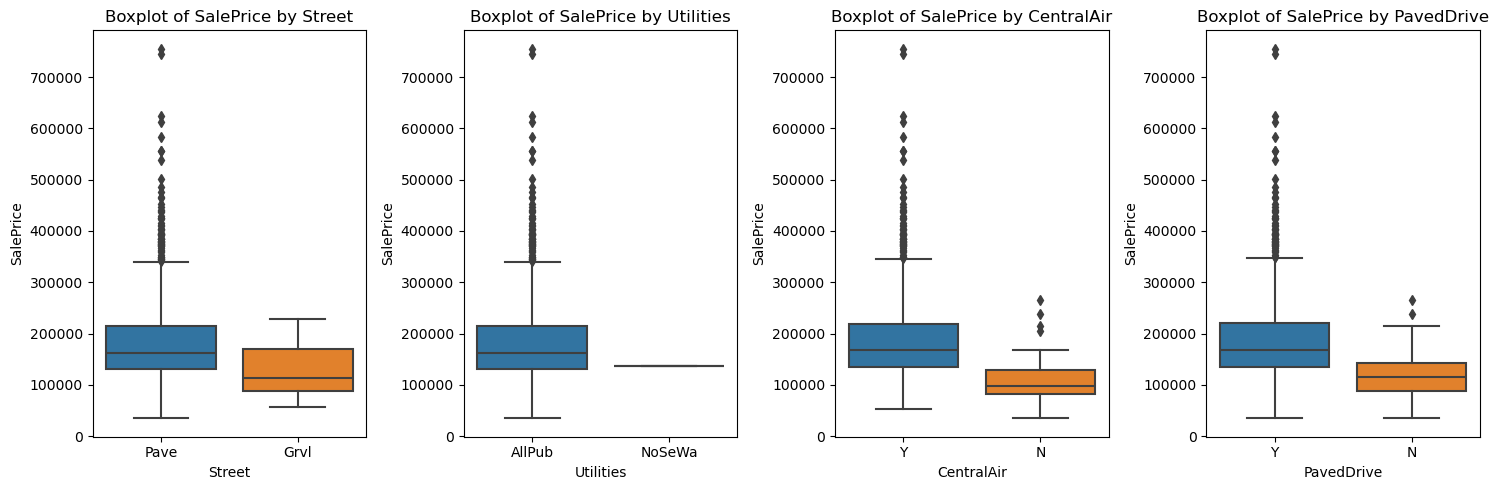

In [14]:
# convert Paved Drive to dichotomous, indicator variable
housing_training_data['PavedDrive'] = np.where(housing_training_data['PavedDrive'] == 'Y', 'Y', 'N')
housing_training_data['PavedDrive'].value_counts()

# view indicator variables
indicator_vars = ['Street', 'Utilities', 'CentralAir','PavedDrive']

# Create subplots for each indicator variable
fig, ax = plt.subplots(1, 4, figsize=(15, 5))

# Iterate through each indicator variable and create boxplots
for var, subplot in zip(indicator_vars, ax.flatten()):
    sns.boxplot(x=var, y='SalePrice', data=housing_training_data, ax=subplot)
    subplot.set_title(f'Boxplot of SalePrice by {var}')
    subplot.set_xlabel(var)
    subplot.set_ylabel('SalePrice')

# Adjust layout and display the plots
fig.tight_layout()
plt.show();

In [15]:
# Run T-tests for each indicator variable
Street_t_test = ttest_ind(
    housing_training_data['SalePrice'][housing_training_data['Street'] == 'Pave'],
    housing_training_data['SalePrice'][housing_training_data['Street'] == 'Grvl'], equal_var=False
)

Utilities_t_test = ttest_ind(
    housing_training_data['SalePrice'][housing_training_data['Utilities'] == 'AllPub'],
    housing_training_data['SalePrice'][housing_training_data['Utilities'] == 'NoSeWa'], equal_var=False
)

Central_Air_t_test = ttest_ind(
    housing_training_data['SalePrice'][housing_training_data['CentralAir'] == 'Y'],
    housing_training_data['SalePrice'][housing_training_data['CentralAir'] == 'N'], equal_var=False
)

Paved_Drive_t_test = ttest_ind(
    housing_training_data['SalePrice'][housing_training_data['PavedDrive'] == 'Y'],
    housing_training_data['SalePrice'][housing_training_data['PavedDrive'] == 'N'], equal_var=False
)

# Compile T-test statistics and p-values into lists
Indicator_Variable_t_test_statistics = [Street_t_test[0], Utilities_t_test[0], Central_Air_t_test[0], Paved_Drive_t_test[0]]
Indicator_Variable_t_test_p_values = [Street_t_test[1], Utilities_t_test[1], Central_Air_t_test[1], Paved_Drive_t_test[1]]


indicator_var_t_tests = {
    'Indicator Variable':indicator_vars,
    'T-Test Statistic':Indicator_Variable_t_test_statistics, 
    'P-Values':Indicator_Variable_t_test_p_values
}

# Create a DataFrame from the dictionary
Indicator_var_t_test_df = pd.DataFrame(indicator_var_t_tests)

# Apply background gradient to highlight values in the DataFrame
styled_df = Indicator_var_t_test_df.style.background_gradient(cmap='Greens')

# Display the styled DataFrame
styled_df

,Indicator Variable,T-Test Statistic,P-Values
0,Street,1.900788,0.115048
1,Utilities,nan,nan
2,CentralAir,17.267773,0.000000
3,PavedDrive,15.093535,0.000000


Correlation with SalePrice: Calculate correlation coefficients (such as Pearson correlation) between encoded categorical variables and SalePrice. Higher absolute correlation coefficients suggest stronger relationships, which will guide our selection for ANOVA testing.

In [16]:
# dummy encode the Street, Central Air, Paved Drive indicator variables, we will exclude Utilities from encoding since there is only 
housing_training_data = pd.get_dummies(housing_training_data, columns=['Street','CentralAir','PavedDrive'], drop_first=True)

To determine which categorical variables might be most useful for inclusion in a regression model (in the form of a dichotomous variable), we can create boxplots and run analyses of variance (ANOVA) to determine which non-binary categorical variables may have the strongest relationship with home sale prices.

We can create boxplots to visually display the distribution of sale prices disaggregated by the categories associated with each of the non-indicator categorical variables as well.

In [17]:
# Remove specified items from categorical_variables
categorical_variables_refine = [var for var in categorical_variables if var not in ['Street', 'CentralAir', 'PavedDrive']]

# Encode the categorical variables
encoded_categorical_vars = housing_training_data[categorical_variables_refine].apply(LabelEncoder().fit_transform)

# Calculate correlation with SalePrice
corr_with_saleprice = encoded_categorical_vars.corrwith(housing_training_data['SalePrice'])

# Identify variables with high correlation (absolute value)
relevant_categorical_vars = corr_with_saleprice[abs(corr_with_saleprice) > 0.4].index.tolist()

print("Categorical variables with high correlation with SalePrice:")
print(relevant_categorical_vars)

Categorical variables with high correlation with SalePrice:
['ExterQual', 'BsmtQual', 'HeatingQC', 'KitchenQual', 'GarageType', 'YearBuilt', 'GarageYrBlt']


It looks like we've identified `ExterQual`, `BsmtQual`, `HeatingQC`, `KitchenQual`, `GarageType`, `YearBuilt`, and `GarageYrBlt` as categorical variables that show high correlation with `SalePrice`. These variables are likely to be significant predictors in your analysis. If you need further assistance with analyzing these variables or any other aspect of your project, feel free to ask!

In [18]:
# Define variables for ANOVA analysis
ANOVA_vars = ['ExterQual', 'BsmtQual', 'FireplaceQu', 'KitchenQual', 'GarageQual', 'GarageCond', 'HeatingQC']

# Perform ANOVA for ExterQual
exter_qual_groups = [housing_training_data['SalePrice'][housing_training_data['ExterQual'] == level] for level in ['Gd', 'TA', 'Ex', 'Fa']]
anova_exter_qual = f_oneway(*exter_qual_groups)

# Perform ANOVA for BsmtQual
bsmt_qual_groups = [housing_training_data['SalePrice'][housing_training_data['BsmtQual'] == level] for level in ['Gd', 'TA', 'Ex', 'None', 'Fa']]
anova_bsmt_qual = f_oneway(*bsmt_qual_groups)

# Perform ANOVA for FireplaceQu
fireplace_qu_groups = [housing_training_data['SalePrice'][housing_training_data['FireplaceQu'] == level] for level in ['None', 'TA', 'Gd', 'Fa', 'Ex', 'Po']]
anova_fireplace_qu = f_oneway(*fireplace_qu_groups)

# Perform ANOVA for KitchenQual
kitchen_qual_groups = [housing_training_data['SalePrice'][housing_training_data['KitchenQual'] == level] for level in ['Gd', 'TA', 'Ex', 'Fa']]
anova_kitchen_qual = f_oneway(*kitchen_qual_groups)

# Perform ANOVA for GarageQual
garage_qual_groups = [housing_training_data['SalePrice'][housing_training_data['GarageQual'] == level] for level in ['None', 'TA', 'Gd', 'Fa', 'Ex', 'Po']]
anova_garage_qual = f_oneway(*garage_qual_groups)

# Perform ANOVA for GarageCond
garage_cond_groups = [housing_training_data['SalePrice'][housing_training_data['GarageCond'] == level] for level in ['None', 'TA', 'Gd', 'Fa', 'Ex', 'Po']]
anova_garage_cond = f_oneway(*garage_cond_groups)

# Perform ANOVA for HeatingQC
heating_qc_groups = [housing_training_data['SalePrice'][housing_training_data['HeatingQC'] == level] for level in ['TA', 'Gd', 'Fa', 'Ex', 'Po']]
anova_heating_qc = f_oneway(*heating_qc_groups)

# Collect ANOVA results
anova_stats = [anova_exter_qual.statistic, anova_bsmt_qual.statistic, anova_fireplace_qu.statistic, anova_kitchen_qual.statistic,
               anova_garage_qual.statistic, anova_garage_cond.statistic, anova_heating_qc.statistic]

anova_pvals = [anova_exter_qual.pvalue, anova_bsmt_qual.pvalue, anova_fireplace_qu.pvalue, anova_kitchen_qual.pvalue,
               anova_garage_qual.pvalue, anova_garage_cond.pvalue, anova_heating_qc.pvalue]

anova_results = {'Categorical Variable': ANOVA_vars, 'Test Statistic': anova_stats, 'P-Values': anova_pvals}
anova_df = pd.DataFrame(anova_results)

# Style the DataFrame
anova_df.style.background_gradient(cmap='Greens')

,Categorical Variable,Test Statistic,P-Values
0,ExterQual,443.334831,0.000000
1,BsmtQual,316.148635,0.000000
2,FireplaceQu,121.075121,0.000000
3,KitchenQual,407.806352,0.000000
4,GarageQual,25.776093,0.000000
5,GarageCond,25.750153,0.000000
6,HeatingQC,88.394462,0.000000


In [19]:
# for heatingQC excellent is the only value that is statistically significant from the others, so we will encode this to be a binary variable.
housing_training_data['HeatingEx'] = np.where(housing_training_data['HeatingQC'] == 'Ex', 1, 0)
housing_training_data.drop(columns=['HeatingQC'],inplace=True)

Encode important categorical variables

In [20]:
# List of important categorical features
important_cats = ['ExterQual', 'BsmtQual', 'FireplaceQu', 'KitchenQual', 'GarageQual', 'GarageCond']

# Ordinal mapping for categorical features
ordinal_map = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'None': 1, 'Po': 0 }

# Replace categorical values with ordinal rankings
for feature in important_cats:
    housing_training_data[feature] = housing_training_data[feature].replace(ordinal_map)

# Display the shape of the data
print(f'Shape all_data: {housing_training_data.shape}')

Shape all_data: (1460, 77)


### Feature Creation

We will create a new feature to represent the number of years since a home was last remodeled, which may enhance the accuracy of our home sale price prediction models.

Pearson correlation coefficient and p-value for SalePrice and Years since House was remodeled/built:
Correlation coefficient: -0.5090787380156276
P-value: 4.374855446379975e-97


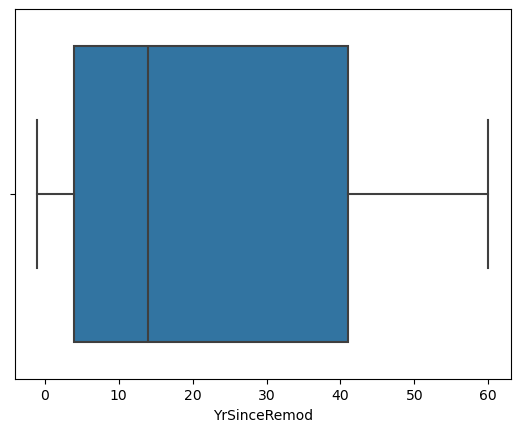

In [21]:
# Create a new variable: years since the house was remodeled from selling date (use construction date if no remodeling or additions)
housing_training_data['YrSinceRemod'] = housing_training_data['YrSold'] - housing_training_data['YearRemodAdd'];

# Create a boxplot for YrSinceRemod
sns.boxplot(x='YrSinceRemod', data=housing_training_data);

# Compute Pearson correlation coefficient and p-value for SalePrice and YrSinceRemod
correlation_coefficient, p_value = stats.pearsonr(housing_training_data['YrSinceRemod'], housing_training_data['SalePrice']);
print("Pearson correlation coefficient and p-value for SalePrice and Years since House was remodeled/built:");
print("Correlation coefficient:", correlation_coefficient);
print("P-value:", p_value);

Additionally, we'll create a feature to represent the total square footage of the home, which can further contribute to our home sale price prediction models.

Pearson correlation coefficient and p-value for SalePrice and TotalSF (Total square feet - includes basement):
Correlation coefficient: 0.8199962912972798
P-value: 0.0


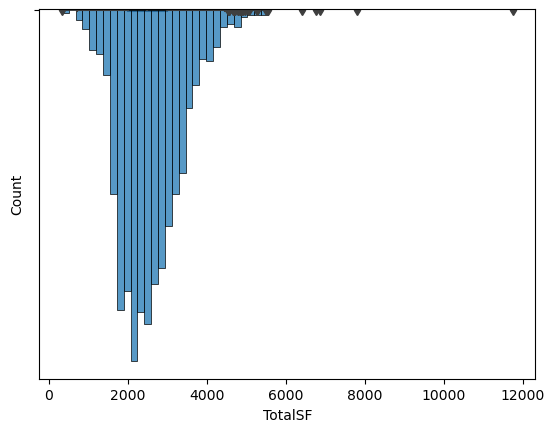

In [22]:
# Create a new variable: Total square feet (TotalSF)
housing_training_data['TotalSF'] = housing_training_data['TotalBsmtSF'] + housing_training_data['GrLivArea']

# Create a boxplot for TotalSF
sns.boxplot(x='TotalSF', data=housing_training_data);

# Drop large outliers from the dataframe
housing_training_data.drop(housing_training_data[housing_training_data['TotalSF'] > 6000].index, inplace=True)

# Visualize distribution without extreme outliers
sns.histplot(data=housing_training_data, x="TotalSF");

# Compute Pearson correlation coefficient and p-value for SalePrice and TotalSF
correlation_coefficient, p_value = stats.pearsonr(housing_training_data['TotalSF'], housing_training_data['SalePrice']);
print("Pearson correlation coefficient and p-value for SalePrice and TotalSF (Total square feet - includes basement):");
print("Correlation coefficient:", correlation_coefficient);
print("P-value:", p_value);

### Dummy Encoding

Let's dummy encode the remaining categorical variables and create a new dataframe with these encoded columns and the original numeric columns.

In [23]:
# create new df with current numeric columns
housing_training_numeric_df = pd.DataFrame(housing_training_data.select_dtypes(exclude=['object']))
housing_training_object_df = pd.DataFrame(housing_training_data.select_dtypes(exclude=['uint8','int','float']))
orig_object_cols = housing_training_object_df.columns
housing_training_data_dummy = pd.get_dummies(housing_training_object_df, columns=orig_object_cols)
housing_training_data_large = pd.concat([housing_training_numeric_df, housing_training_data_dummy], axis=1)
housing_training_data_large.head()
housing_training_data_large.shape

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Street_Pave_False,Street_Pave_True,CentralAir_Y_False,CentralAir_Y_True,PavedDrive_Y_False,PavedDrive_Y_True
0,1,60,65.0,8450,7,5,2003,2003,196.0,3,...,False,False,True,False,False,True,False,True,False,True
1,2,20,80.0,9600,6,8,1976,1976,0.0,2,...,False,False,True,False,False,True,False,True,False,True
2,3,60,68.0,11250,7,5,2001,2002,162.0,3,...,False,False,True,False,False,True,False,True,False,True
3,4,70,60.0,9550,7,5,1915,1970,0.0,2,...,False,False,False,False,False,True,False,True,False,True
4,5,60,84.0,14260,8,5,2000,2000,350.0,3,...,False,False,True,False,False,True,False,True,False,True


(1455, 262)

In [24]:
# Calculate the correlation matrix
corrmat_housing_training = housing_training_data_large.corr()
cor_target = abs(corrmat_housing_training["SalePrice"])
relevant_features = cor_target[cor_target > 0.25]
feature_list = relevant_features.index
housing_training_data_large_subset = housing_training_data_large[feature_list]
housing_training_data_large_subset.shape

(1455, 53)

We may use this dataframe later on in the analysis. For the start, we will investigate the relationship between SalePrice and a select number of features, like Total Square Feet.

## Prepare Test Data

In [25]:
# load test data
housing_testing_data = pd.read_csv('test.csv')

Handle Null values, matches how we dealt with Nulls in the training dataset

In [26]:
# Find null counts, percentage of null values, and column type
null_count = housing_testing_data.isnull().sum()
null_percentage = housing_testing_data.isnull().sum() * 100 / len(housing_testing_data)
column_type = housing_testing_data.dtypes
null_summary = pd.concat([null_count, null_percentage, column_type], axis=1, keys=['Missing Count', 'Percentage Missing', 'Column Type'])
null_summary_only_missing = null_summary[null_count != 0].sort_values('Percentage Missing', ascending=False)

In [27]:
# Remove columns with over 50% missing values
housing_testing_data.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)
columns_None = ['SaleType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType',
                'GarageFinish', 'GarageQual', 'MSZoning', 'FireplaceQu', 'Functional', 'Utilities', 'GarageCond',
                'MasVnrType', 'Exterior2nd', 'Exterior1st']

# Set Nulls in non-numeric columns to 'None'
housing_testing_data[columns_None] = housing_testing_data[columns_None].fillna('None')
columns_zero = ['MasVnrArea', 'GarageArea', 'GarageCars', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2', 
                'BsmtFinSF1', 'BsmtHalfBath', 'BsmtFullBath', 'BsmtQual', 'KitchenQual']

housing_testing_data[columns_zero] = housing_testing_data[columns_zero].fillna(0)
housing_testing_data['LotFrontage'].fillna(housing_testing_data['LotFrontage'].median(), inplace=True)
housing_testing_data['GarageYrBlt'].fillna(housing_testing_data['GarageYrBlt'].median(), inplace=True)

In [28]:
# Convert Paved Drive to dichotomous, indicator variable
housing_testing_data['PavedDrive'] = np.where(housing_testing_data['PavedDrive'] == 'Y', 'Y', 'N')
housing_testing_data['PavedDrive'].value_counts()
housing_testing_data = pd.get_dummies(housing_testing_data, columns=['Street', 'CentralAir', 'PavedDrive'], drop_first=True)

PavedDrive
Y    1301
N     158
Name: count, dtype: int64

In [29]:
# for heatingQC encode this to be a binary variable to match how we encoded this column in training data
housing_testing_data['HeatingEx'] = np.where(housing_testing_data['HeatingQC'] == 'Ex', 1, 0)
housing_testing_data.drop(columns=['HeatingQC'],inplace=True)

In [30]:
# encode categorical columns with ordinal values
important_categorical = ['ExterQual', 'BsmtQual', 'FireplaceQu', 'KitchenQual', 'GarageQual','GarageCond']

ordinal_mapping = { 'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'None': 1, 'Po': 0 }

# process columns, replace to categorical features with ordinal ranking
for i in important_categorical:
    housing_testing_data[i] = housing_testing_data[i].replace(ordinal_mapping)

# shape        
print('Shape all_data: {}'.format(housing_testing_data.shape))

Shape all_data: (1459, 76)


In [31]:
# create new variable TotalSF
housing_testing_data['TotalSF'] = housing_testing_data['TotalBsmtSF'] + housing_testing_data['GrLivArea']
housing_testing_data['YrSinceRemod'] = housing_testing_data['YrSold'] - housing_testing_data['YearRemodAdd']

### Dummy Encoding

In [32]:
# create new df with current numeric columns
housing_testing_numeric_data = pd.DataFrame(housing_testing_data.select_dtypes(exclude=['object']))

# create new df with current categorical columns
housing_testing_object_data = pd.DataFrame(housing_testing_data.select_dtypes(exclude=['uint8','int','float']))
orig_object_cols = housing_testing_object_data.columns

# dummy encode the categorical columns
housing_testing_data_dummy = pd.get_dummies(housing_testing_object_data, columns=orig_object_cols)

# create new df with original numeric and new dummy encoded columns
housing_testing_data_large = pd.concat([housing_testing_numeric_data, housing_testing_data_dummy], axis=1)
housing_testing_data_large.shape

(1459, 252)

In [33]:
# create new dataframe with correlated variables with SalePrice observed in the training data
feature_list = feature_list.drop('SalePrice')
housing_testing_data_large_subset = housing_testing_data_large[feature_list]
housing_testing_data_large_subset.shape

(1459, 52)

In [34]:
# Find the common columns
common_columns = housing_testing_data_large.columns.intersection(housing_training_data_large.columns)
housing_testing_data_large_common = housing_testing_data_large[common_columns]
housing_training_data_large_common = housing_training_data_large[common_columns]

### Constructing Models to Predict Home Prices

## Lasso Regression

We will now try to fit a Lasso Regression to the housing sales dataframe.

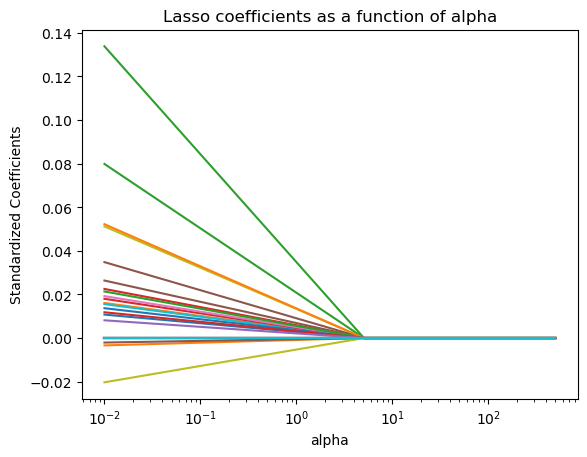

In [35]:
# Create dataframe that can be used for lasso.  Only keep variables that aren't causing error messages
lasso_sandbox = housing_training_data[ ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
                 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
                 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
                 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']]
                                      
# Perform a Log Transformation on the outcome variable SalePrice and drop the original variable
lasso_sandbox_log_saleprice = np.log(housing_training_data['SalePrice'])
lasso_sandbox_x = lasso_sandbox.drop(columns=['SalePrice'])

# Split the dataset into training and testing dataframes
lasso_X_train, lasso_X_validation, lasso_y_train, lasso_y_validation = train_test_split(lasso_sandbox_x,
                                                                            lasso_sandbox_log_saleprice, test_size=0.3, random_state=1)

# Standardize the numeric predictors - which can help strengthen the model fit
numerical_predictors = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
                 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
                 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
                 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

lasso_scaler = StandardScaler().fit(lasso_X_train[numerical_predictors]) 
lasso_X_train[numerical_predictors] = lasso_scaler.transform(lasso_X_train[numerical_predictors])
lasso_X_validation[numerical_predictors] = lasso_scaler.transform(lasso_X_validation[numerical_predictors])

alphas = np.linspace(0.01,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(lasso_X_train, lasso_y_train)
    coefs.append(lasso.coef_)

ax = plt.gca();

ax.plot(alphas, coefs);
ax.set_xscale('log');
plt.axis('tight');
plt.xlabel('alpha');
plt.ylabel('Standardized Coefficients');
plt.title('Lasso coefficients as a function of alpha');

# Fit a Lasso Regression Model with ten-fold cross-validation
lasso_model = LassoCV(cv=5, random_state=1, max_iter = 10000)
lasso_model.fit(lasso_X_train, lasso_y_train);

# lasso_model.coef_

Let's plot the mean squared error as a function of our tuning parameter, alpha, from our cross-validation

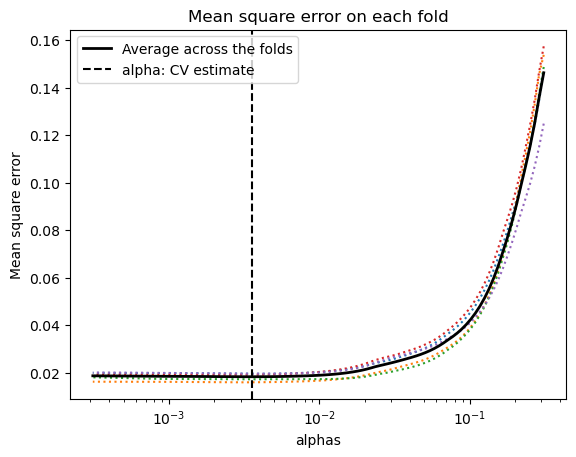

In [36]:
plt.semilogx(lasso_model.alphas_, lasso_model.mse_path_, ":")
plt.plot(lasso_model.alphas_ , lasso_model.mse_path_.mean(axis=-1), "k", label="Average across the folds", linewidth=2);
plt.axvline(lasso_model.alpha_, linestyle="--", color="k", label="alpha: CV estimate" );

plt.legend();
plt.xlabel("alphas");
plt.ylabel("Mean square error");
plt.title("Mean square error on each fold");
plt.axis("tight");

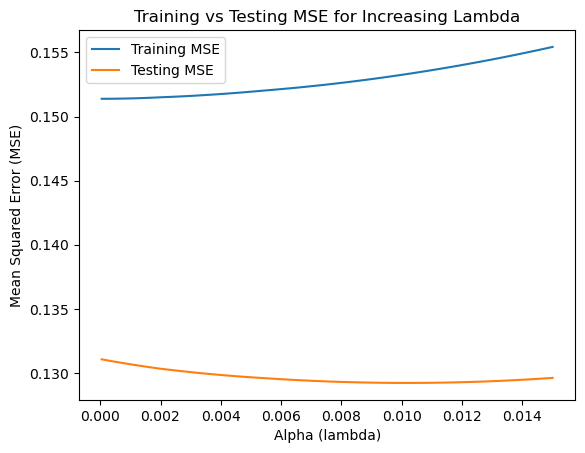

In [37]:
# Initialize Lasso model
lasso = Lasso(max_iter=10000)

# Define alpha values (lambda values)
alphas = np.linspace(0.00005, 0.015, 100)

# Scale the predictors and target
scaler = StandardScaler()
lasso_x = scaler.fit_transform(lasso_sandbox_x)
lasso_y = scaler.fit_transform(np.array(lasso_sandbox['SalePrice']).reshape(-1, 1))

# Split the dataset into training and testing dataframes
lasso_X_train, lasso_X_validation, lasso_y_train, lasso_y_validation = train_test_split(lasso_x, lasso_y, test_size=0.3, random_state=1)

# Lists to store training and testing MSE
training_mse = []
testing_mse = []

# Loop through each alpha value
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(lasso_X_train, lasso_y_train)
    # Calculate MSE for training and testing sets
    training_mse.append(mean_squared_error(lasso_y_train, lasso.predict(lasso_X_train)))
    testing_mse.append(mean_squared_error(lasso_y_validation, lasso.predict(lasso_X_validation)))

# Plot training vs testing MSE for increasing lambda
plt.plot(alphas, training_mse, label='Training MSE')
plt.plot(alphas, testing_mse, label='Testing MSE')
plt.xlabel('Alpha (lambda)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training vs Testing MSE for Increasing Lambda')
plt.legend()
plt.show();

In [38]:
def regmodel_param_test(
    alphas_to_try, X, y, cv, scoring = 'r2', 
    model_name = 'LASSO', X_test = None, y_test = None, 
    draw_plot = False, filename = None):
    
    validation_scores = []
    train_scores = []
    results_list = []
    if X_test is not None:
        test_scores = []
        scorer = get_scorer(scoring)
    else:
        test_scores = None

    for curr_alpha in alphas_to_try:
        
        if model_name == 'LASSO':
            regmodel = Lasso(alpha = curr_alpha)
        elif model_name == 'Ridge':
            regmodel = Ridge(alpha = curr_alpha)
        elif model_name == 'ElasticNet':
            regmodel = ElasticNet(alpha = curr_alpha)
        else:
            return None

        results = cross_validate(
            regmodel, X, y, scoring=scoring, cv=cv, 
            return_train_score = True)

        validation_scores.append(np.mean(results['test_score']))
        train_scores.append(np.mean(results['train_score']))
        results_list.append(results)

        if X_test is not None:
            regmodel.fit(X,y)
            y_pred = regmodel.predict(X_test)
            test_scores.append(scorer(regmodel, X_test, y_test))
    
    chosen_alpha_id = np.argmax(validation_scores)
    chosen_alpha = alphas_to_try[chosen_alpha_id]
    max_validation_score = np.max(validation_scores)
    if X_test is not None:
        test_score_at_chosen_alpha = test_scores[chosen_alpha_id]
    else:
        test_score_at_chosen_alpha = None
        
    if draw_plot:
        regmodel_param_plot(
            validation_scores, train_scores, alphas_to_try, chosen_alpha, 
            scoring, model_name, test_scores, filename)
    
    return chosen_alpha, max_validation_score, test_score_at_chosen_alpha

def regmodel_param_plot(
    validation_score, train_score, alphas_to_try, chosen_alpha,
    scoring, model_name, test_score = None, filename = None):
    
    plt.figure(figsize = (8,8))
    sns.lineplot(y = validation_score, x = alphas_to_try, label = 'validation_data')
    sns.lineplot(y = train_score, x = alphas_to_try, label = 'training_data')
    plt.axvline(x=chosen_alpha, linestyle='--')
    if test_score is not None:
        sns.lineplot(y = test_score, x = alphas_to_try, label = 'test_data')
    plt.xlabel('alpha_parameter')
    plt.ylabel(scoring)
    plt.title(model_name + ' Regularisation')
    plt.legend()
    plt.show()

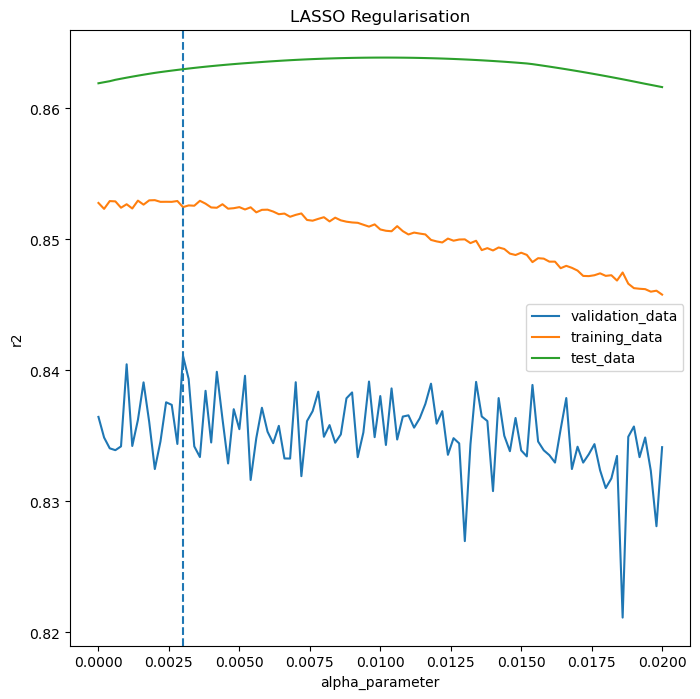

Chosen alpha: 0.00300
Validation score: 0.84110
Test score at chosen alpha: 0.86299


In [39]:
cv = KFold(n_splits=5, shuffle=True)

lasso_alphas = np.linspace(0, 0.02, 101)
chosen_alpha, max_validation_score, test_score_at_chosen_alpha = \
    regmodel_param_test( lasso_alphas, lasso_X_train, lasso_y_train, cv, scoring = 'r2', model_name = 'LASSO', 
        X_test = lasso_X_validation, y_test = lasso_y_validation,  draw_plot = True, filename = 'lasso_wide_search')
print("Chosen alpha: %.5f" %chosen_alpha)
print("Validation score: %.5f" %max_validation_score)
print("Test score at chosen alpha: %.5f" %test_score_at_chosen_alpha)

Let's evaluate the performance of the best Lasso model that we were able to construct

In [40]:
# Show best value of tuning parameter (alpha) chosen by cross validation
print(f"The best value of the tuning parameter, alpha, chosen by cross-validation is {lasso_model.alpha_}.")
lasso_best = Lasso(alpha=lasso_model.alpha_)
lasso_best.fit(lasso_X_train, lasso_y_train)
best_lasso_coeffs_data = (list(zip(lasso_X_train, lasso_best.coef_)))
best_lasso_coeffs_df = pd.DataFrame(best_lasso_coeffs_data, columns = ['Predictor', 'Best Lasso Coefficient'])

The best value of the tuning parameter, alpha, chosen by cross-validation is 0.0035778259276540757.


Lasso(alpha=0.0035778259276540757)

In [41]:
# Calculate the R squared for the training and validation datasets
lasso_r_squared_train = round(lasso_best.score(lasso_X_train, lasso_y_train), 3)
lasso_r_squared_validation = round(lasso_best.score(lasso_X_validation, lasso_y_validation), 3)
print(f"The R squared for the best Lasso model for the training set is: {lasso_r_squared_train}.")
print(f"The R squared for the best Lasso model for the validation set is: {lasso_r_squared_validation}.")
lasso_y_predictions_train = lasso_model.predict(lasso_X_train)
lasso_mse_train = mean_squared_error(lasso_y_train, lasso_y_predictions_train)
print(f"The mean squared error of the Lasso Regression model's predictions using the log home sale prices in the training dataset is {lasso_mse_train}.")
lasso_y_predictions_validation = lasso_model.predict(lasso_X_validation)
lasso_mse_validation = mean_squared_error(lasso_y_validation, lasso_y_predictions_validation)
print(f"The mean squared error of the Lasso Regression model's predictions using the log home sale prices in the validation dataset is {lasso_mse_validation}.")

The R squared for the best Lasso model for the training set is: 0.851.
The R squared for the best Lasso model for the validation set is: 0.863.
The mean squared error of the Lasso Regression model's predictions using the log home sale prices in the training dataset is 144.98172527888673.
The mean squared error of the Lasso Regression model's predictions using the log home sale prices in the validation dataset is 146.1750136575638.


### Rework LASSO analysis on full set of variables including encoded

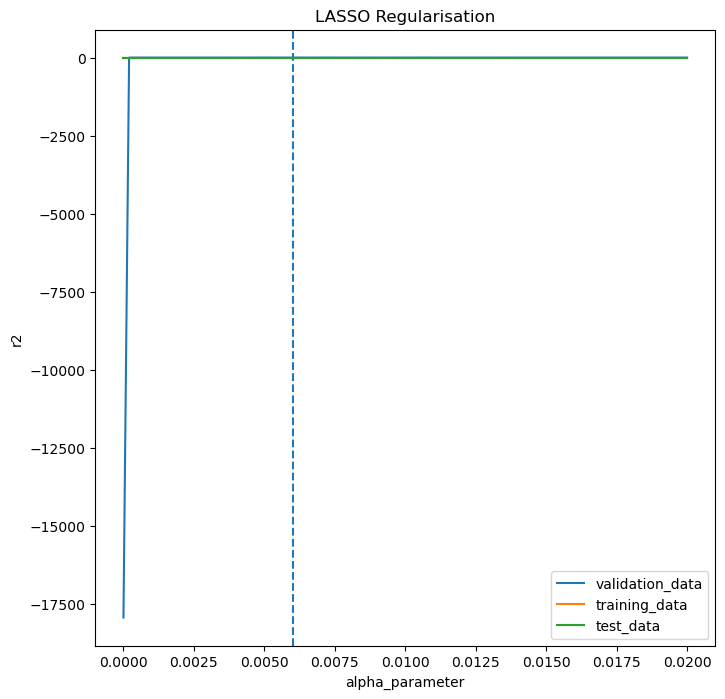

Chosen alpha: 0.00600
Validation score: 0.90326
Test score at chosen alpha: -5.52195


In [42]:
# Split the dataset into training and testing dataframes
scaler = StandardScaler()
x_raw = housing_training_data_large.select_dtypes(exclude=['object']).drop(columns = ['SalePrice'])
x_scale = scaler.fit_transform(x_raw)
y_scale = scaler.fit_transform(np.array(housing_training_data['SalePrice']).reshape(-1,1))
y = housing_training_data_large['SalePrice']
new_lasso_X_train, new_lasso_X_validation, new_lasso_y_train, new_lasso_y_validation = train_test_split(x_scale, y, test_size=0.3, random_state=1)
cv = KFold(n_splits=5, shuffle=True)

lasso_alphas = np.linspace(0, 0.02, 101)

chosen_alpha, max_validation_score, test_score_at_chosen_alpha = \
    regmodel_param_test( lasso_alphas, x_scale, y_scale, cv, scoring = 'r2', model_name = 'LASSO', 
        X_test = new_lasso_X_validation, y_test = new_lasso_y_validation, draw_plot = True, filename = 'lasso_wide_search')
print("Chosen alpha: %.5f" % chosen_alpha)
print("Validation score: %.5f" % max_validation_score)
print("Test score at chosen alpha: %.5f" % test_score_at_chosen_alpha)

In [43]:
### BASED ON LASSOCV:
print(f"The best value of the tuning parameter, alpha, chosen by cross-validation is {lasso_model.alpha_}.")
lasso_best = Lasso(alpha=lasso_model.alpha_)
lasso_best.fit(x_scale, y_scale)
# lasso_best.coef_

The best value of the tuning parameter, alpha, chosen by cross-validation is 0.0035778259276540757.


Lasso(alpha=0.0035778259276540757)

### repeat the process with RIDGE MODEL

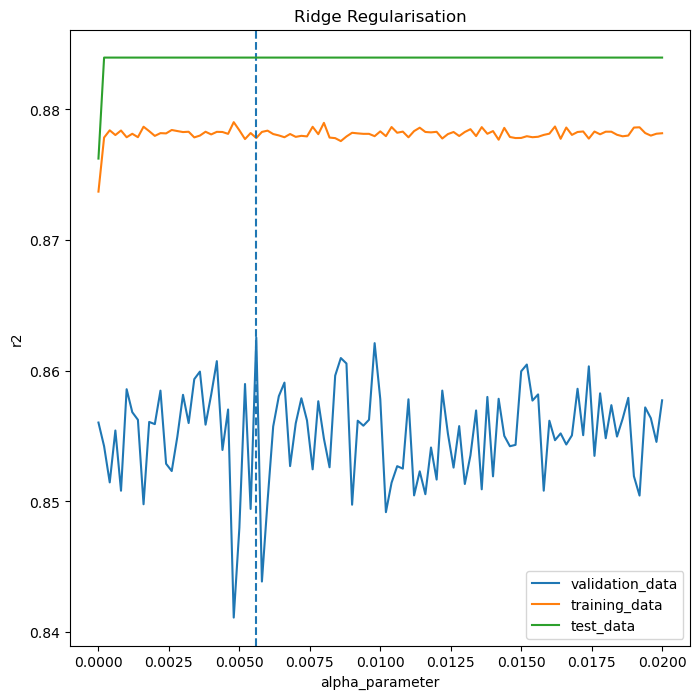

Chosen alpha: 0.00560
Validation score: 0.86254
Test score at chosen alpha: 0.88396


In [44]:
# Split the dataset into training and testing dataframes
scaler = StandardScaler()
x_raw = housing_training_data.select_dtypes(exclude=['object']).drop(columns = ['SalePrice'])
x_scale = scaler.fit_transform(x_raw)
y_scale = np.array(housing_training_data['SalePrice']).reshape(-1,1)

new_ridge_X_train, new_ridge_X_validation, new_ridge_y_train, new_ridge_y_validation = train_test_split(x_scale, y_scale, test_size=0.3, random_state=1)
cv = KFold(n_splits=5, shuffle=True)

lasso_alphas = np.linspace(0, 0.02, 101)

chosen_alpha, max_validation_score, test_score_at_chosen_alpha = \
    regmodel_param_test( lasso_alphas, new_ridge_X_train, new_ridge_y_train, cv, scoring = 'r2', model_name = 'Ridge', 
        X_test = new_ridge_X_validation, y_test = new_ridge_y_validation, draw_plot = True, filename = 'ridge_wide_search')
print("Chosen alpha: %.5f" % chosen_alpha)
print("Validation score: %.5f" % max_validation_score)
print("Test score at chosen alpha: %.5f" % test_score_at_chosen_alpha)

### REPEAT WITH RIDGE USING SUBNET OF ENCODED VARIABLE SET

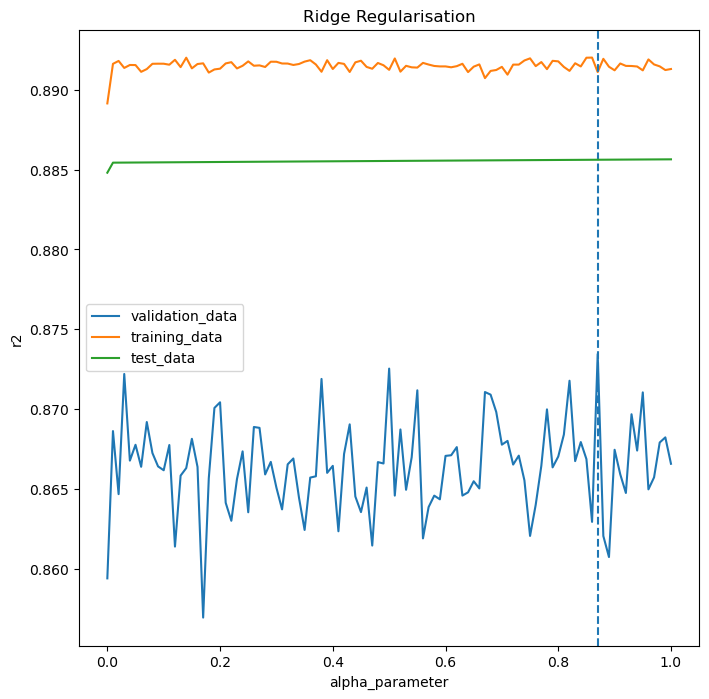

Chosen alpha: 0.87000
Validation score: 0.87345
Test score at chosen alpha: 0.88562


In [45]:
scaler = StandardScaler()
x_raw = housing_training_data_large_subset.select_dtypes(exclude=['object']).drop(columns = ['SalePrice'])
x_scale = scaler.fit_transform(x_raw)
y_scale = np.array(housing_training_data['SalePrice']).reshape(-1,1)

new_ridge_X_train, new_ridge_X_validation, new_ridge_y_train, new_ridge_y_validation = train_test_split(x_scale, y_scale, test_size=0.3, random_state=1)
cv = KFold(n_splits=5, shuffle=True)

lasso_alphas = np.linspace(0, 1, 101)

chosen_alpha, max_validation_score, test_score_at_chosen_alpha = \
    regmodel_param_test( lasso_alphas, new_ridge_X_train, new_ridge_y_train, cv, scoring = 'r2', model_name = 'Ridge', 
        X_test = new_ridge_X_validation, y_test = new_ridge_y_validation, draw_plot = True, filename = 'ridge_wide_search')
print("Chosen alpha: %.5f" %chosen_alpha)
print("Validation score: %.5f" %max_validation_score)
print("Test score at chosen alpha: %.5f" %test_score_at_chosen_alpha)

### ElasticNet Model 

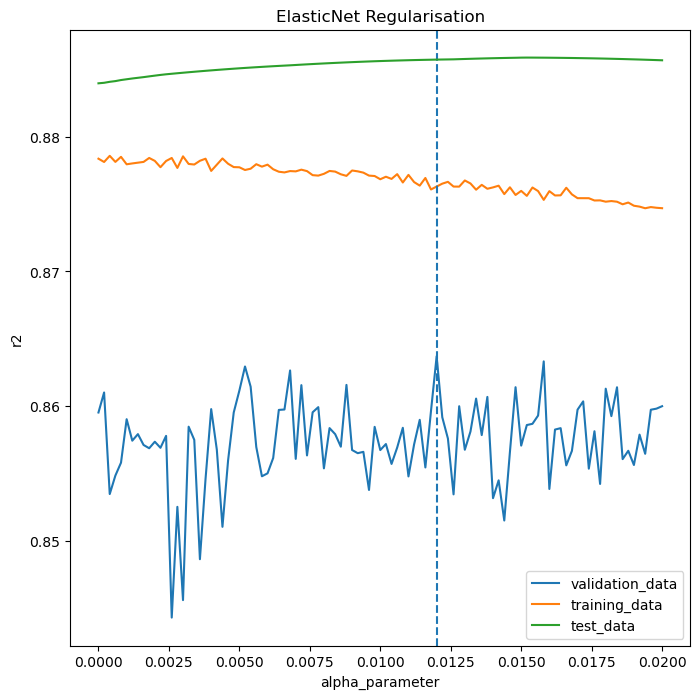

Chosen alpha: 0.01200
Validation score: 0.86371
Test score at chosen alpha: 0.88572


In [46]:
# Split the dataset into training and testing dataframes
elasticscaler = StandardScaler()
x_raw = housing_training_data.select_dtypes(exclude=['object']).drop(columns = ['SalePrice'])
x_scale = scaler.fit_transform(x_raw)
y_scale = elasticscaler.fit_transform(np.array(housing_training_data['SalePrice']).reshape(-1,1))

new_elastic_X_train, new_elastic_X_validation, new_elastic_y_train, new_elastic_y_validation = train_test_split(x_scale, y_scale, test_size=0.3, random_state=1)
cv = KFold(n_splits=5, shuffle=True)

lasso_alphas = np.linspace(0, 0.02, 101)

chosen_alpha, max_validation_score, test_score_at_chosen_alpha = \
    regmodel_param_test(lasso_alphas, new_elastic_X_train, new_elastic_y_train, cv, scoring = 'r2', model_name = 'ElasticNet', 
        X_test = new_elastic_X_validation, y_test = new_elastic_y_validation, draw_plot = True, filename = 'EN_wide_search')
print("Chosen alpha: %.5f" %chosen_alpha)
print("Validation score: %.5f" %max_validation_score)
print("Test score at chosen alpha: %.5f" %test_score_at_chosen_alpha)

### REPEAT WITH ELASTIC NET USING FULL ENCODED VARIABLE SET with LOG TRANSFORMED SALES PRICE

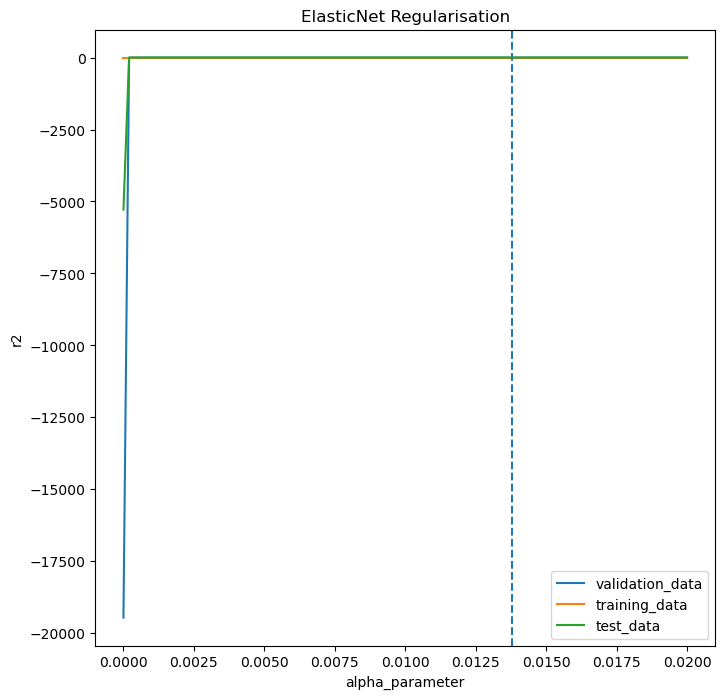

Chosen alpha: 0.01380
Validation score: 0.92382
Test score at chosen alpha: 0.90113


In [47]:
# Split the dataset into training and testing dataframes
elasticscaler = StandardScaler()
x_raw = housing_training_data_large_common.select_dtypes(exclude=['object'])
x_scale = scaler.fit_transform(x_raw)
y_scale = elasticscaler.fit_transform(np.array(np.log(housing_training_data['SalePrice'])).reshape(-1,1))

new_elastic_X_train, new_elastic_X_validation, new_elastic_y_train, new_elastic_y_validation = train_test_split(x_scale, y_scale, test_size=0.3, random_state=1)
cv = KFold(n_splits=5, shuffle=True)
lasso_alphas = np.linspace(0, 0.02, 101)

chosen_alpha, max_validation_score, test_score_at_chosen_alpha = \
    regmodel_param_test( lasso_alphas, new_elastic_X_train, new_elastic_y_train, cv, scoring = 'r2', model_name = 'ElasticNet', 
        X_test = new_elastic_X_validation, y_test = new_elastic_y_validation, draw_plot = True, filename = 'EN_wide_search')
print("Chosen alpha: %.5f" %chosen_alpha)
print("Validation score: %.5f" %max_validation_score)
print("Test score at chosen alpha: %.5f" %test_score_at_chosen_alpha)

Let's check the coefficients to determine the important predictors in the model

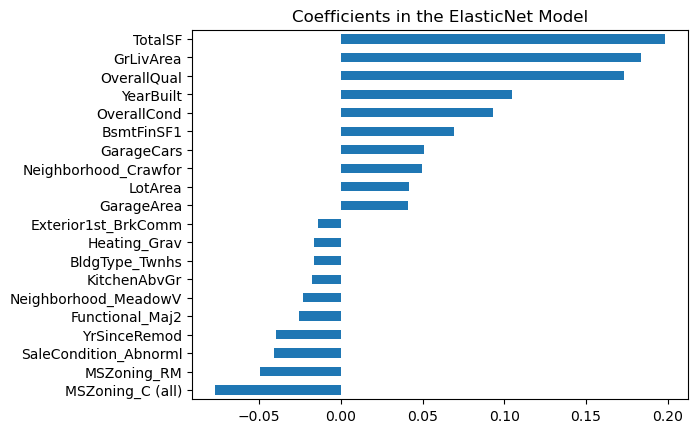

In [48]:
regr = ElasticNet(alpha=chosen_alpha)
elastic_model = regr.fit(x_scale, y_scale)

coef = pd.Series(elastic_model.coef_, index = x_raw.columns)
important_features = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
important_features.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model");

TotalSF, GrLivArea, and Overall Quality appear to have strong, positive effects on Sales Price.

## Running Models on Test Data for Kaggle Predictions

### Kaggle Results - Lasso Regression

In [49]:
# Set up Test dataframe for Lasso Regression Analysis
lasso_X_test = housing_testing_data.copy(deep=True)
lasso_X_test = lasso_X_test[ ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
                'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
                'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
                'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']]

lasso_X_test[numerical_predictors] = lasso_scaler.transform(lasso_X_test[numerical_predictors])

In [50]:
# Exponential transform the predictions (since the model output log transformed y-values)
lasso_y_predictions_test = lasso_model.predict(lasso_X_test)
y_predictions_final_lasso = np.exp(lasso_y_predictions_test)
predictiondf_lasso=pd.DataFrame(y_predictions_final_lasso, columns=['SalePrice'])
predictiondf_lasso.insert(0, 'Id', housing_testing_data['Id'])
predictiondf_lasso.to_csv('salesprice_lasso_model.csv', index=False)

### Kaggle Results - Elastic Regression

In [51]:
x_raw = housing_testing_data_large_common.select_dtypes(exclude=['object'])
x_scale = scaler.fit_transform(x_raw)
y_scale_elastic_pred = elastic_model.predict(x_scale)
if y_scale_elastic_pred.ndim == 1:
    y_scale_elastic_pred = y_scale_elastic_pred.reshape(-1, 1)

# transform the predictions (since the model output scaled y-values)
y_log_elastic_pred = elasticscaler.inverse_transform(y_scale_elastic_pred)
y_elastic_pred = np.exp(y_log_elastic_pred)

In [52]:
# Create a dataframe with the y predictions 
predictiondf_elastic=pd.DataFrame(y_elastic_pred, columns=['SalePrice'])
predictiondf_elastic.insert(0, 'Id', housing_testing_data['Id'])
predictiondf_elastic.to_csv('salesprice_elastic_model.csv', index=False)